In [79]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf


import invisible_cities.io.mcinfo_io as mcio


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize


import core.functions as func

import imageio

### Read in Beersheba data

In [62]:
path = '/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/beersheba/'
df = pd.read_hdf(path + 'beersheba_1_208Tl.h5', 'DECO/Events')
events = np.unique(df.event.to_numpy())

# also load in MC
dfMC = mcio.load_mchits_df(path + 'beersheba_1_208Tl.h5').reset_index()
eventsMC = np.unique(dfMC.event_id.to_numpy())

In [63]:
display(df)
display(dfMC)

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
0,0,0.0,370.675,-191.325,776.835872,0.000020,368.346366,-174.196321,1.373371e+06,0,0,0
1,0,0.0,370.675,-190.325,776.835872,0.000020,368.346366,-174.196321,1.373371e+06,0,0,0
2,0,0.0,371.675,-193.325,776.835872,0.000021,368.346366,-174.196321,1.373371e+06,0,0,0
3,0,0.0,371.675,-192.325,776.835872,0.000026,368.346366,-174.196321,1.373371e+06,0,0,0
4,0,0.0,371.675,-191.325,776.835872,0.000027,368.346366,-174.196321,1.373371e+06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2495392,648,2.0,121.675,-56.325,724.623506,0.000002,104.680861,-60.381546,6.488070e+08,0,0,0
2495393,648,2.0,121.675,-55.325,724.623506,0.000003,104.680861,-60.381546,6.488070e+08,0,0,0
2495394,648,2.0,121.675,-54.325,724.623506,0.000003,104.680861,-60.381546,6.488070e+08,0,0,0
2495395,648,2.0,121.675,-53.325,724.623506,0.000003,104.680861,-60.381546,6.488070e+08,0,0,0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,0,39,0,386.361053,-182.384506,781.322083,2.307219,0.000069,ACTIVE
1,0,39,1,261.051025,-37.941269,863.623169,3.568978,0.000011,ACTIVE
2,0,47,0,214.329819,210.628296,797.141357,4.448271,0.000221,ACTIVE
3,0,62,0,214.330002,210.628357,797.141479,4.448344,0.000023,ACTIVE
4,0,61,0,214.329865,210.628296,797.141418,4.448293,0.000045,ACTIVE
...,...,...,...,...,...,...,...,...,...
117403,324,46,7,131.310883,-206.131348,44.084183,2.968418,0.001434,ACTIVE
117404,324,46,8,131.303696,-206.124832,44.088520,2.968658,0.001053,ACTIVE
117405,324,46,9,131.300247,-206.122803,44.081619,2.968858,0.001334,ACTIVE
117406,324,46,10,131.297440,-206.118759,44.081928,2.969004,0.001585,ACTIVE


### Find events that have summed energy ~ 1.6 MeV

In [64]:
Es = {}

for evt, df2 in df.groupby('event'):
    if (df2.E.sum() > 1.5) and (df2.E.sum() < 1.65):
        Es[evt] = df2.E.sum()

In [65]:
print("MC event numbers and energies")
display(Es)

MC event numbers and energies


{92: 1.5812873469952198,
 122: 1.6212296398915096,
 152: 1.5377282341711749,
 198: 1.592416654051363,
 270: 1.600101216413033,
 304: 1.567905175211018,
 322: 1.5576460077341954,
 340: 1.5897949643520182,
 372: 1.5348721772005653,
 400: 1.639464976115445,
 418: 1.6143654438064827,
 428: 1.609802382114864,
 504: 1.5126624498158283,
 516: 1.5949894144284817,
 542: 1.5993788248553849,
 610: 1.5849585452508879,
 620: 1.5007937878430417}

In [111]:
evt_num = 100

# select an event
evt = events[evt_num]
evtMC = eventsMC[evt_num]
print("Selected event: {} ({} MC)".format(evt, evtMC))

data = df[df.event == evt]
dataMC = dfMC[dfMC.event_id == evtMC]
display(data)
display(dataMC)

Selected event: 200 (100 MC)


,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
767774,200,0.0,410.675,104.675,375.949022,0.000092,399.48042,134.044006,2.002375e+08,0,0,0
767775,200,0.0,410.675,105.675,375.949022,0.000098,399.48042,134.044006,2.002375e+08,0,0,0
767776,200,0.0,410.675,106.675,375.949022,0.000094,399.48042,134.044006,2.002375e+08,0,0,0
767777,200,0.0,411.675,103.675,375.949022,0.000101,399.48042,134.044006,2.002375e+08,0,0,0
767778,200,0.0,411.675,104.675,375.949022,0.000117,399.48042,134.044006,2.002375e+08,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
776495,200,0.0,369.675,135.675,466.450458,0.000108,399.48042,134.044006,2.002375e+08,0,0,0
776496,200,0.0,369.675,136.675,466.450458,0.000110,399.48042,134.044006,2.002375e+08,0,0,0
776497,200,0.0,369.675,137.675,466.450458,0.000108,399.48042,134.044006,2.002375e+08,0,0,0
776498,200,0.0,369.675,138.675,466.450458,0.000102,399.48042,134.044006,2.002375e+08,0,0,0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
35904,100,22,0,467.537231,174.190033,386.349213,0.928052,0.000006,ACTIVE
35905,100,22,1,467.504730,174.169022,386.395996,0.928262,0.000125,ACTIVE
35906,100,22,2,467.496338,174.163239,386.408875,0.928319,0.000010,ACTIVE
35907,100,22,3,467.459717,174.136185,386.466278,0.928572,0.000130,ACTIVE
35908,100,22,4,467.423950,174.110886,386.523071,0.928820,0.000059,ACTIVE
...,...,...,...,...,...,...,...,...,...
36463,100,37,15,428.810699,160.045212,400.618683,1.102900,0.001416,ACTIVE
36464,100,37,16,428.811462,160.050217,400.611115,1.103118,0.001037,ACTIVE
36465,100,37,17,428.810913,160.056778,400.610504,1.103294,0.001463,ACTIVE
36466,100,37,18,428.811005,160.054337,400.613068,1.103412,0.001721,ACTIVE


#### display data

Text(0.5, 0.98, '3D_deconvolved_plot_200')

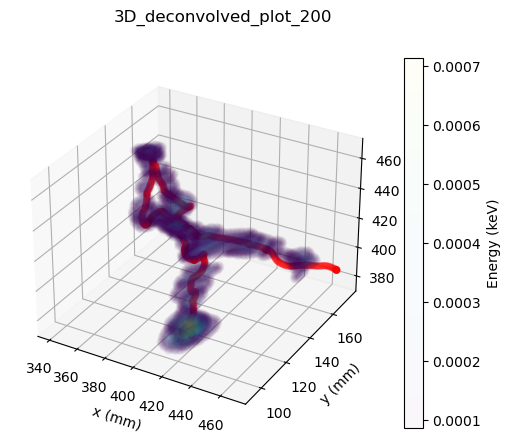

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x = data.X
y = data.Y
z = data.Z
e = data.E

xt = dataMC.x
yt = dataMC.y
zt = dataMC.z
et = dataMC.energy*1000

em = e > 0.00005
#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis', zorder=0.3)
q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')
#ax.scatter(xt, yt, zt, color='red', zorder = 0.5)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(40, 60)

fig.suptitle('3D_deconvolved_plot_' + str(evt))

In [113]:
rotation = False

In [69]:

if rotation==True:
  rotation_space = np.linspace(0, 359, 30, endpoint = True)

  for i in (rotation_space):
    fig = plt.figure()
    fig.suptitle('3D post deconvolution ' + str(evt), fontsize=20)
    ax = fig.add_subplot(111, projection='3d')
    #em = e > 0.00005 # eliminate small things for measurement
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis')
    q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')

    # overlay the blobs and their radii

    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Energy (keV)')

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')
    ax.view_init(20, -i)
    plt.savefig(f'gif_making/deconv/angle_{i}.png')
    plt.close(fig)

In [70]:
if rotation == True:
    
    files = [f for f in os.listdir('gif_making/deconv/') if os.path.isfile(os.path.join('gif_making/deconv/', f))]

    #sort files in a human manner
    files.sort(key=func.alphanum_key)
    images = []
    for filename in files:
        images.append(imageio.imread('gif_making/deconv/' + filename))
    

    print("Creating gif...")
    gif_name = f'gif_making/output/rotating_track_evt_{evt}.gif'
    imageio.mimsave(gif_name, images, loop = 0, fps = 7)



/tmp/ipykernel_56267/1686658283.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('gif_making/deconv/' + filename))


Creating gif...


<img src=gif_making/output/rotating_track_evt_200.gif width="750" align="center">

<img src=gif_making/output/rotating_track_evt_610.gif width="750" align="center">

### manipulate the data to be skeleton worthy

/tmp/ipykernel_56267/2231545188.py:57: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


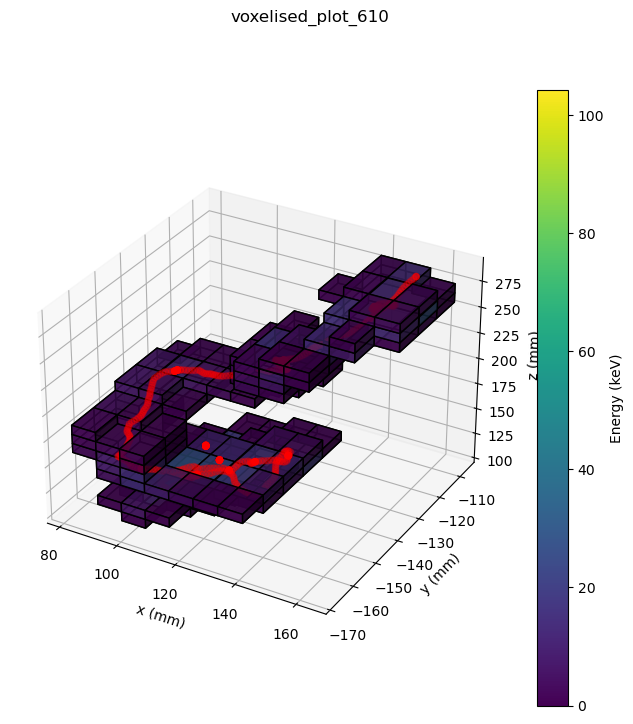

In [84]:
# voxelise
base_vsize = 9 #mm
the_hits = []

xs = data.X
ys = data.Y
zs = data.Z
es = data.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')
q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')

fig.suptitle('voxelised_plot_' + str(evt))
plt.show()

#### Take the voxels and make them 0 or 1 in 3D array


In [93]:
print(VOXELS.shape)
print(VOXELS[0])
# its already the right format

(10, 7, 20)
[[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 

In [97]:
skeleton = skeletonize_3d(VOXELS)
skeleton_mask = np.where(skeleton == 1)

/tmp/ipykernel_56267/926034516.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0, 'z (mm)')

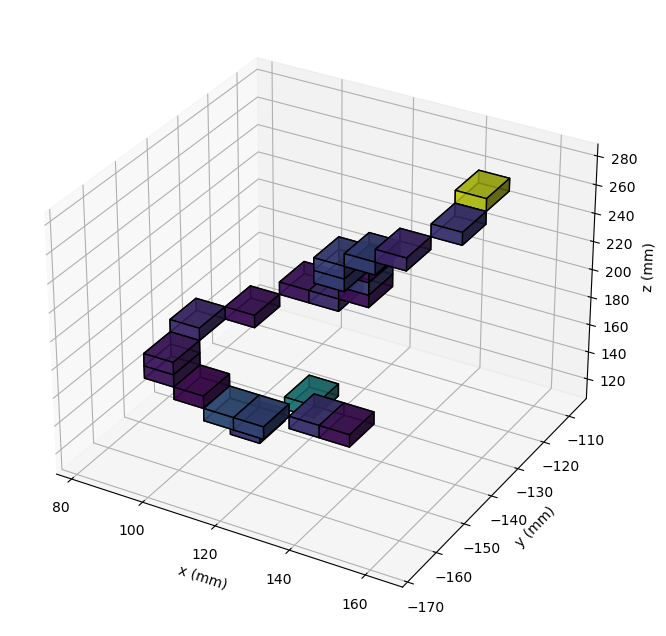

In [98]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, skeleton, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


With isaura, its a bit gross. Lets try beersheba directly

In [99]:
def apply_skeleton(df):
    
    x = df.X.values
    y = df.Y.values
    z = df.Z.values
    
    xx = np.linspace(x.min() - 0.5, x.max() + 0.5, int(x.max() - x.min() + 2))
    yy = np.linspace(y.min() - 0.5, y.max() + 0.5, int(y.max() - y.min() + 2))
    zz = shift_to_bin_centers(df.Z.unique())
    
    zz = np.append(zz, zz[-1] + 1)
    zz = np.append(zz[0] - 1, zz)
    values = np.histogramdd((x, y, z), bins=[xx, yy, zz])    
    val    = values[0].transpose(2,0,1).flatten()
    digitize = np.where(values[0] > 0, 1, 0)
    skeleton = skeletonize_3d(digitize)
    #if skeleton.sum() > 0:
    skeleton_mask = np.where(skeleton == 1)
    x_skel = shift_to_bin_centers(xx)[skeleton_mask[0]]
    y_skel = shift_to_bin_centers(yy)[skeleton_mask[1]]
    z_skel = shift_to_bin_centers(zz)[skeleton_mask[2]]
    e_skel = values[0][skeleton_mask]
    
    return pd.DataFrame({'X':x_skel, 'Y':y_skel, 'Z':z_skel, 'E':e_skel})


In [100]:
df_skel = apply_skeleton(data)

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/skimage/util/dtype.py:550: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [101]:
display(df_skel)

,X,Y,Z,E
0,85.675,-158.325,181.245688,1.0
1,86.675,-157.325,181.245688,1.0
2,87.675,-158.325,177.962868,1.0
3,88.675,-158.325,177.962868,1.0
4,89.675,-157.325,177.962868,1.0
...,...,...,...,...
221,150.675,-114.325,281.673057,1.0
222,150.675,-113.325,281.673057,1.0
223,151.675,-122.325,272.313956,1.0
224,152.675,-121.325,272.313956,1.0


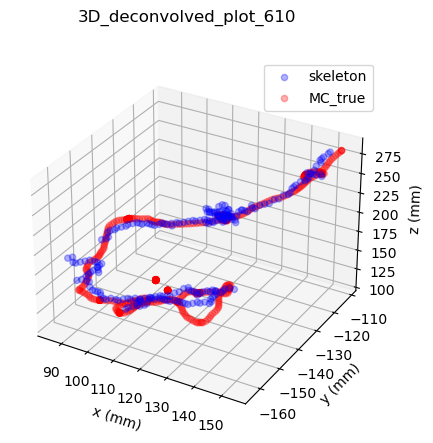

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x_skel = df_skel.X
y_skel = df_skel.Y
z_skel = df_skel.Z
e_skel = df_skel.E

p = ax.scatter(x_skel, y_skel, z_skel, alpha=0.3, color = 'blue', zorder=0.3, label = 'skeleton')
q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red', label = 'MC_true')

#ax.scatter(xt, yt, zt, color='red', zorder = 0.5)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(40, 60)
plt.legend()
fig.suptitle('3D_deconvolved_plot_' + str(evt))
plt.show()